# Employer Review Prediction
## Reynara Ezra Pratama

## Background

## Business Understanding

1. Mengetahui *review* yang diberikan oleh pegawai terhadap perusahaan.
2. Memprediksi *review* yang diberikan dan mengkategorikannya ke dalam *review* yang bersifat positif, netral, atau negatif.

## Data Understanding

1. `ReviewTitle` : Topik dari *review*.
2. `CompleteReview` : *Review* yang diberikan pegawai perusahaan.
3. `URL` : *Uniform Resource Locator*.
4. `Rating` : Penilaian yang diberikan pegawai perusahaan.
5. `ReviewDetails` : Detail mengenai *review*.

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import tensorflow as tf
import nltk
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Loading Dataset

**Load Data From Github**

In [2]:
url = "https://raw.githubusercontent.com/ReynaraEzra/Employer-Review/main/data_input/results.json"
df = pd.read_json(url)

**Load Data From Local File**

In [3]:
# df = pd.read_json('data_input/results.json')

## Checking Dataset

In [4]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,..."
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021"
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021"
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Current Employee) - - August 17, 2021"
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1,"(Former Employee) - - August 9, 2021"


In [5]:
df.tail()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails
145204,Definitely very good place to work and can hav...,We get a lot to learn in the company. Very sys...,https://in.indeed.com/cmp/Tata-Consultancy-Ser...,4,"(Former Employee) - - January 20, 2012"
145205,IT Services Company; Great scope for improvement.,Lot of scope to learn different technologies u...,https://in.indeed.com/cmp/Tata-Consultancy-Ser...,4,"(Former Employee) - - January 19, 2012"
145206,"Productive, fun to work, great place to do cer...","An overall positive experience, nice environme...",https://in.indeed.com/cmp/Tata-Consultancy-Ser...,4,"(Former Employee) - - January 19, 2012"
145207,Great place to start the career.,Happy that I've started my career from such a ...,https://in.indeed.com/cmp/Tata-Consultancy-Ser...,3,"(Former Employee) - - January 7, 2012"
145208,Nice place to work,Got good experience and knowledge about my wor...,https://in.indeed.com/cmp/Tata-Consultancy-Ser...,5,"(Former Employee) - - December 19, 2011"


In [6]:
df.sample(5)

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails
83242,It's good,Overall ok..I can not say is good for work bec...,https://in.indeed.com/cmp/HSBC/reviews?start=620,3,"(Former Employee) - - July 26, 2018"
20589,Hard working and happiest working place,Over all working culture at reliance is good a...,https://in.indeed.com/cmp/Reliance-Industries-...,4,"(Current Employee) - Dehej, Gujarat - Marc..."
29102,Productive and challenging,A person grows as professional with ample amou...,https://in.indeed.com/cmp/Deloitte/reviews?sta...,4,"(Former Employee) - - January 20, 2020"
40336,A Heaven to work in,"I would like to say that, it was my dream comp...",https://in.indeed.com/cmp/Infosys/reviews?star...,5,"(Current Employee) - - August 20, 2020"
28515,Ideal workplace for an employee.,This company is one of the top companies in In...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - July 18, 2015"


## Check Characteristic Data

**Data Shape**

In [7]:
df.shape

(145209, 5)

**Data Columns**

In [8]:
df.columns

Index(['ReviewTitle', 'CompleteReview', 'URL', 'Rating', 'ReviewDetails'], dtype='object')

**Data Info**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145209 entries, 0 to 145208
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ReviewTitle     145209 non-null  object
 1   CompleteReview  145209 non-null  object
 2   URL             145209 non-null  object
 3   Rating          145209 non-null  int64 
 4   ReviewDetails   145209 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.5+ MB


**Descriptive Statistic**

In [10]:
df.describe()

,Rating
count,145209.000000
mean,4.053661
std,0.925805
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000


**Check Missing Value**

In [11]:
df.isnull().sum()

ReviewTitle       0
CompleteReview    0
URL               0
Rating            0
ReviewDetails     0
dtype: int64

**Check and Drop Duplicate Data**

In [12]:
df = df.drop_duplicates(keep='first')
df.reset_index(drop=True, inplace=True)

In [13]:
df.shape

(145191, 5)

## Feature Extraction

In [14]:
df.head(3)

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,..."
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021"
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021"


**Make Company Name Columns**

In [15]:
df['Company Name'] = df['URL'].str.split('/')
df['Company Name'] = df['Company Name'].str[4]

In [16]:
df['Company Name'].head()

0    Reliance-Industries-Ltd
1    Reliance-Industries-Ltd
2    Reliance-Industries-Ltd
3    Reliance-Industries-Ltd
4    Reliance-Industries-Ltd
Name: Company Name, dtype: object

In [17]:
df['Company Name'].unique()

array(['Reliance-Industries-Ltd', 'Mphasis', 'Kpmg', 'Yes-Bank',
       'Sutherland', 'Marriott-International,-Inc.', 'DHL', 'Jio',
       'Vodafoneziggo', 'HP', 'Maersk', 'Ride.swiggy', 'Jll', 'Alstom',
       'UnitedHealth-Group', 'Tata-Consultancy-Services-(tcs)',
       'Capgemini', 'Teleperformance', 'Cognizant-Technology-Solutions',
       'Mahindra-&-Mahindra-Ltd', 'L&T-Technology-Services-Ltd.',
       'Bharti-Airtel-Limited', 'Indeed', 'Hyatt',
       'Icici-Prudential-Life-Insurance', 'Accenture', 'Honeywell',
       'Standard-Chartered-Bank', 'Nokia', 'Apollo-Hospitals',
       'Tata-Aia-Life', 'Hdfc-Bank', 'Bosch', 'Deloitte', 'Ey',
       'Microsoft', 'Barclays', 'JPMorgan-Chase', 'Muthoot-Finance',
       'Wns-Global-Services', 'Kotak-Mahindra-Bank', 'Infosys', 'Oracle',
       "Byju's", 'Deutsche-Bank', 'Hinduja-Global-Solutions', 'Ericsson',
       'Axis-Bank', 'IBM', 'Concentrix', 'Wells-Fargo', 'Google',
       'Dell-Technologies', 'Facebook', 'Amazon.com', 'Flipkart.

In [18]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company Name
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Current Employee) - - August 17, 2021",Reliance-Industries-Ltd
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1,"(Former Employee) - - August 9, 2021",Reliance-Industries-Ltd


**Make Date Columns**

In [19]:
df['Date'] = df['ReviewDetails'].str.split('-', expand=True)[2]

In [20]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company Name,Date
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd,"August 30, 2021"
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd,"August 26, 2021"
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd,"August 17, 2021"
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Current Employee) - - August 17, 2021",Reliance-Industries-Ltd,"August 17, 2021"
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1,"(Former Employee) - - August 9, 2021",Reliance-Industries-Ltd,"August 9, 2021"


**Make Year, Month, Day Columns**

In [21]:
df['Year'] = df['Date'].str.split(',', expand=True)[1]

In [22]:
df['Month'] = df['Date'].str.split(' ', expand=True)[2]

In [23]:
df['Day'] = df['Date'].str.split(' ', expand=True)[3]
df['Day'] = df['Day'].str.replace(',','')

**Check Columns**

Column `Year`

In [24]:
df['Year'].unique()

array([' 2021', ' 2020', ' 2019', ' 2018', ' 2017', ' 2016', None,
       ' 2015', ' 2014', ' 2013', ' 2012', ' 2011',
       ' GWAL PAHARI GURGAON  ', ' airoli  ', ' Malad west  ',
       ' Sp Infocity & Quadra ', ' New Delhi', ' Tamil nadu  ',
       'Gurgaon  '], dtype=object)

In [25]:
df['Year'] = df['Year'].str.replace(' ','')

In [26]:
df['Year'].unique()

array(['2021', '2020', '2019', '2018', '2017', '2016', None, '2015',
       '2014', '2013', '2012', '2011', 'GWALPAHARIGURGAON', 'airoli',
       'Maladwest', 'SpInfocity&Quadra', 'NewDelhi', 'Tamilnadu',
       'Gurgaon'], dtype=object)

In [27]:
df['Year'].value_counts(sort=False)

2014                 15016
GWALPAHARIGURGAON        1
2016                 15295
2018                 15782
SpInfocity&Quadra        1
2019                 16985
2013                 11140
2021                  2967
2012                  4153
airoli                   1
Gurgaon                  1
Tamilnadu                1
2011                    38
2020                 12674
NewDelhi                 1
2015                 13664
Maladwest                1
2017                 37335
Name: Year, dtype: int64

In [28]:
df['Year'].isnull().sum()

135

In [29]:
valid_year = ['2011', '2012', '2013', '2014', '2014', '2015', 
               '2016', '2017', '2018', '2019', '2020', '2021']
df['Year'] = df['Year'].apply(lambda x:x if x in valid_year else np.nan)

In [30]:
df['Year'].value_counts()

2017    37335
2019    16985
2018    15782
2016    15295
2014    15016
2015    13664
2020    12674
2013    11140
2012     4153
2021     2967
2011       38
Name: Year, dtype: int64

In [31]:
df['Year'].isnull().sum()

142

Column `Month`

In [32]:
df['Month'].unique()

array(['August', 'July', 'September', 'May', 'June', 'April', 'March',
       'February', 'January', 'December', 'November', 'October', '',
       'Africa', 'bagh', 'Consultant', 'Road', '9', '.CLUSTER', '(west)',
       'West', 'PAHARI', 'mumbai', None, 'west', 'Ramannagar', 'West.',
       'Raman', 'park', 'Technohub', 'Solutions', 'Office', 'Estate',
       'Infocity', 'Nagar', 'Delhi,', 'Tamil', 'parel', ')', 'Locatino',
       'complex'], dtype=object)

In [33]:
df['Month'].value_counts()

March         15438
January       12626
June          12573
July          12214
September     12090
February      12008
May           11848
April         11667
August        11635
November      11397
October       10945
December      10608
                114
bagh              1
West.             1
parel             1
.CLUSTER          1
park              1
mumbai            1
Nagar             1
Africa            1
Consultant        1
Raman             1
9                 1
West              1
Tamil             1
Technohub         1
Road              1
Delhi,            1
west              1
PAHARI            1
Ramannagar        1
(west)            1
complex           1
Solutions         1
Locatino          1
Infocity          1
Estate            1
)                 1
Office            1
Name: Month, dtype: int64

In [34]:
df['Month'].isnull().sum()

1

In [35]:
valid_month = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = df['Month'].apply(lambda x:x if x in valid_month else np.nan)

In [36]:
df['Month'].value_counts()

March        15438
January      12626
June         12573
July         12214
September    12090
February     12008
May          11848
April        11667
August       11635
November     11397
October      10945
December     10608
Name: Month, dtype: int64

In [37]:
df['Month'].isnull().sum()

142

Column `Day`

In [38]:
df['Day'].unique()

array(['30', '26', '17', '9', '22', '18', '7', '8', '5', '3', '15', '6',
       '20', '2', '16', '10', '31', '23', '11', '28', '24', '21', '19',
       '13', '1', '4', '25', '12', '27', '29', '14', None, '',
       'chandigarh', '&', 'GURGAON', 'Nagar', 'malad', 'India', 'nadu'],
      dtype=object)

In [39]:
df['Day'].value_counts()

5             5159
2             4992
4             4969
21            4929
9             4920
8             4910
3             4910
7             4881
17            4864
12            4842
6             4829
22            4828
20            4825
23            4824
18            4823
16            4812
11            4793
19            4721
25            4709
24            4705
28            4691
26            4684
10            4680
15            4664
27            4660
13            4572
1             4557
14            4466
29            4311
30            4138
31            2381
                80
&                2
GURGAON          1
Nagar            1
chandigarh       1
malad            1
nadu             1
India            1
Name: Day, dtype: int64

In [40]:
valid_day = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
             '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
df['Day'] = df['Day'].apply(lambda x:x if x in valid_day else np.nan)

In [41]:
df['Day'].isnull().sum()

142

**Check Missing Value**

In [42]:
df.isnull().sum()

ReviewTitle         0
CompleteReview      0
URL                 0
Rating              0
ReviewDetails       0
Company Name        0
Date                0
Year              142
Month             142
Day               142
dtype: int64

In [43]:
df.shape

(145191, 10)

In [44]:
df = df.dropna()

In [45]:
df.shape

(145049, 10)

In [46]:
df.isnull().sum()

ReviewTitle       0
CompleteReview    0
URL               0
Rating            0
ReviewDetails     0
Company Name      0
Date              0
Year              0
Month             0
Day               0
dtype: int64

**Create Date Columns**

In [47]:
df['Date'] = df['Year']+df['Month']+df['Day']
df['Date'] = pd.to_datetime(df['Date'], format='%Y%B%d')

In [48]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company Name,Date,Year,Month,Day
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd,2021-08-30,2021,August,30
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd,2021-08-26,2021,August,26
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,2021,August,17
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Current Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,2021,August,17
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1,"(Former Employee) - - August 9, 2021",Reliance-Industries-Ltd,2021-08-09,2021,August,9


**Create Employee Status Columns**

In [49]:
df['Employee Status'] = df['ReviewDetails'].str.split('-', expand=True)[0]

In [50]:
df['Employee Status'].unique()

array(['(Current Employee)  ', '(Former Employee)  ',
       'Training   (Former Employee)  ', 'Officer   (Former Employee)  ',
       'Leader   (Current Employee)  ',
       'health care   (Current Employee)  ',
       'Good team worker   (Former Employee)  ',
       'Officer   (Current Employee)  ',
       'Sr.G.M.Engineering and projects .   (Former Employee)  ',
       'Hospitality   (Former Employee)  ',
       'Employee   (Current Employee)  ',
       'Employee   (Former Employee)  ', 'Worker   (Former Employee)  ',
       'SBI PR outbound    (Current Employee)  ',
       'PR in SBI outbound    (Current Employee)  ',
       'SBI PR    (Former Employee)  ', 'Senior   (Former Employee)  ',
       'Sbi inbound    (Current Employee)  ',
       'KOTAK CARD    (Current Employee)  ',
       'Marketing   (Current Employee)  ', 'Yes   (Current Employee)  ',
       'Kotak cardit card    (Current Employee)  ',
       'Kotak cards    (Current Employee)  ',
       'OFFICER   (Current Employee

In [51]:
df['Employee Status']

0         (Current Employee)  
1          (Former Employee)  
2          (Former Employee)  
3         (Current Employee)  
4          (Former Employee)  
                  ...         
145186     (Former Employee)  
145187     (Former Employee)  
145188     (Former Employee)  
145189     (Former Employee)  
145190     (Former Employee)  
Name: Employee Status, Length: 145049, dtype: object

In [52]:
def get_status_employee(row_value):
    return 'Former Employee' if 'Former Employee' in row_value else 'Current Employee'

In [53]:
df['Employee Status'] = df.apply(lambda x: get_status_employee(x['Employee Status']), axis=1)

In [54]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company Name,Date,Year,Month,Day,Employee Status
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd,2021-08-30,2021,August,30,Current Employee
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd,2021-08-26,2021,August,26,Former Employee
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,2021,August,17,Former Employee
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Current Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,2021,August,17,Current Employee
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1,"(Former Employee) - - August 9, 2021",Reliance-Industries-Ltd,2021-08-09,2021,August,9,Former Employee


## Exploratory Data Analysis (EDA)

In [55]:
def make_count_plot(data, xlabel, size_x, size_y):
    plt.figure(figsize=(size_x, size_y))
    sns.countplot(data)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Number of Reviews Based on {xlabel}', fontsize=15)
    plt.show()

In [56]:
def make_count_plot_hue(data, xlabel, size_x, size_y, hue):
    plt.figure(figsize=(size_x, size_y))
    sns.countplot(data, hue=hue)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Number of Reviews Based on {xlabel}', fontsize=15)
    plt.show()

In [57]:
def make_count_plot_order(data, xlabel, size_x, size_y, order):
    plt.figure(figsize=(size_x, size_y))
    sns.countplot(data, order=order)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Number of Reviews Based on {xlabel}', fontsize=15)
    plt.show()

**Status Employee**

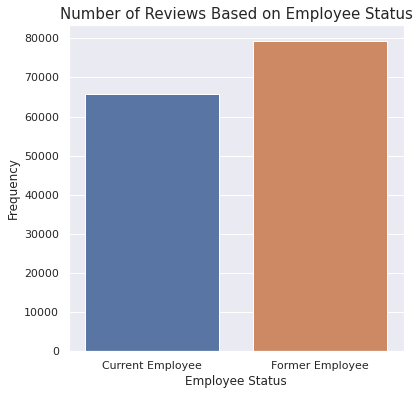

In [58]:
make_count_plot(df['Employee Status'], 'Employee Status', 6, 6)

**Based on Year**

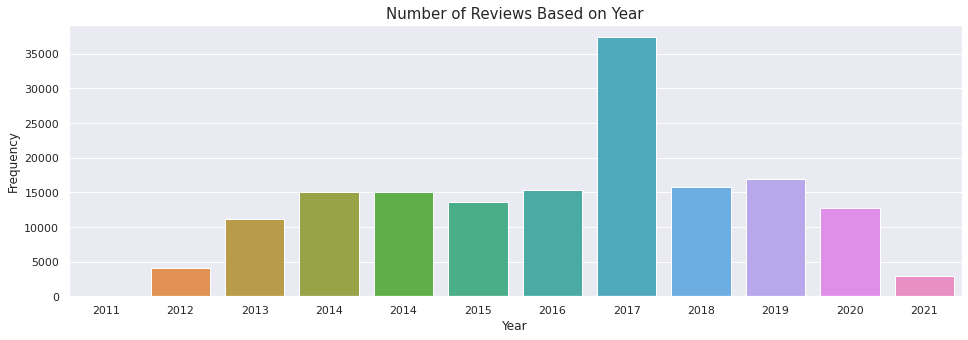

In [59]:
make_count_plot_order(df['Year'], 'Year', 16, 5, valid_year)

**Based on Month**

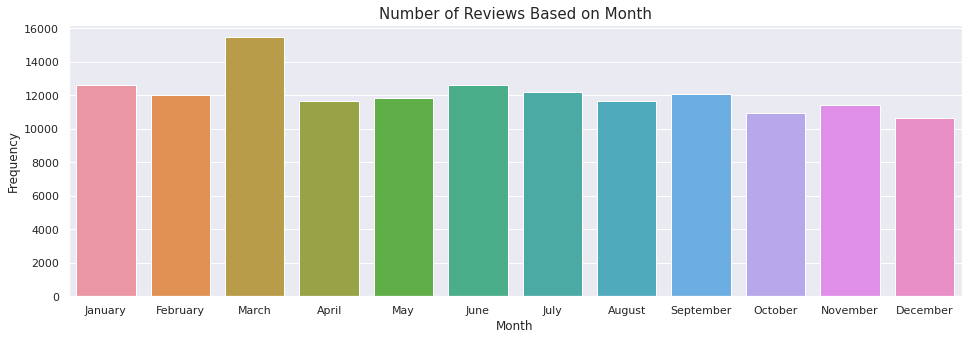

In [60]:
make_count_plot_order(df['Month'], 'Month', 16, 5, valid_month)

**Rating**

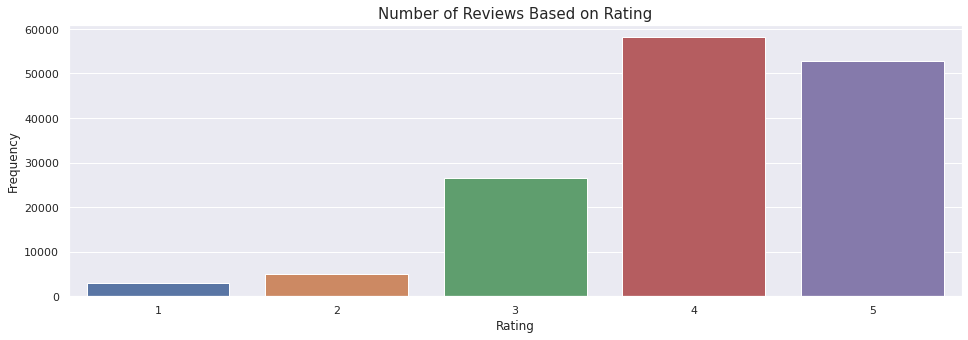

In [61]:
make_count_plot(df['Rating'], 'Rating', 16, 5)

**Company Name**

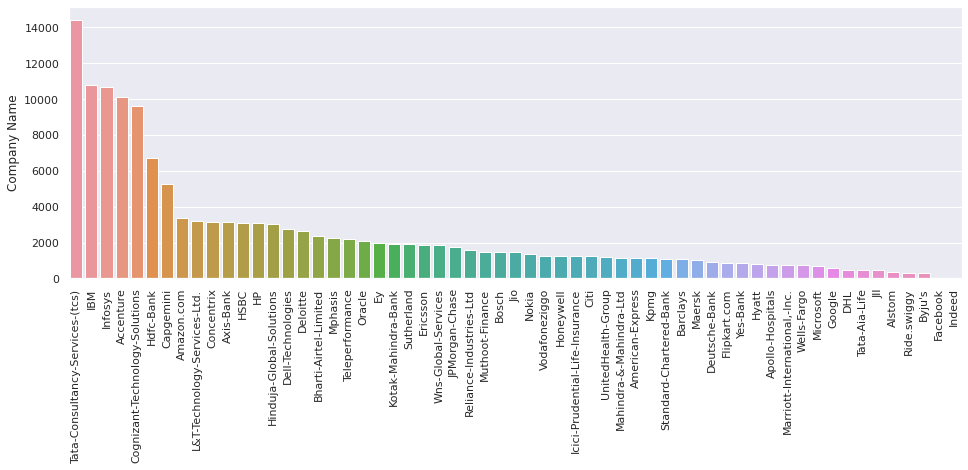

In [62]:
plt.figure(figsize=(16,5))
df_company = df['Company Name'].value_counts()
sns.barplot(x=df_company.index,
            y=df_company)
plt.xticks(rotation=90)
plt.show()

**Rating Based on Employee Status**

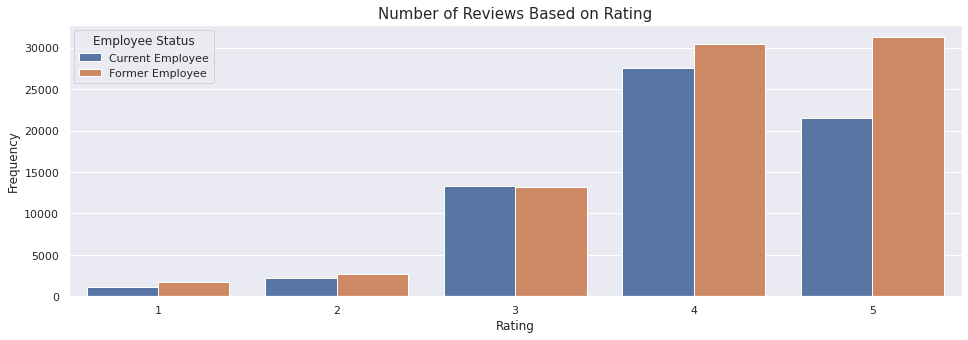

In [63]:
make_count_plot_hue(df['Rating'], 'Rating', 16, 5, hue=df['Employee Status'])

## Build Model

In [64]:
df['Category'] = df['Rating'].replace({1:'Negative', 2:'Negative', 3:'Neutral', 4:'Positive', 5:'Positive'})

In [65]:
df = df.reset_index(drop=True)

In [66]:
df.head(3)

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company Name,Date,Year,Month,Day,Employee Status,Category
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd,2021-08-30,2021,August,30,Current Employee,Neutral
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd,2021-08-26,2021,August,26,Former Employee,Neutral
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,2021,August,17,Former Employee,Positive


In [67]:
df_grp_1 = df['Category'].value_counts()

## Build Model Without Oversampling

### Number of Review

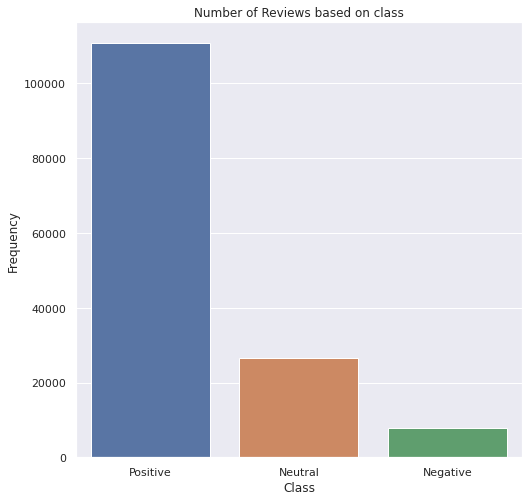

In [68]:
plt.figure(figsize=(8,8))
sns.barplot(x=df_grp_1.index, y=df_grp_1)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Number of Reviews based on class')
plt.show()

### Text Preprocessing

**One Hot Encoding**

In [69]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
df_category = pd.DataFrame(ohe.fit_transform(df[['Category']]))
df_category.columns = df['Category'].sort_values().unique()
df_category = df_category.astype('int64')
df_category.head()

,Negative,Neutral,Positive
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,1,0,0


**Create New Dataframe**

In [70]:
df_new = pd.concat([df['CompleteReview'], df_category], axis=1)

In [71]:
df_new

,CompleteReview,Negative,Neutral,Positive
0,"Good company, cool workplace, work load little...",0,1,0
1,1. Need to work on boss's whims and fancies 2....,0,1,0
2,"Good company for every Engineers dream, Full M...",0,0,1
3,I am just pass out bsc in chemistry Typical da...,0,0,1
4,Not so fun at work just blame games Target pe...,1,0,0
...,...,...,...,...
145044,We get a lot to learn in the company. Very sys...,0,0,1
145045,Lot of scope to learn different technologies u...,0,0,1
145046,"An overall positive experience, nice environme...",0,0,1
145047,Happy that I've started my career from such a ...,0,1,0


**Example**

In [72]:
example = df_new['CompleteReview'].copy()[1]
example

"1. Need to work on boss's whims and fancies 2. Priorities keep changing 3. No regards for work life balance 4. Completing the work before time is stressed too much than completing it well. Involves lots of reworking, blame games; etc. 5. No job boundaries, you will be asked to do any work depending on the requirements."

In [73]:
ps = PorterStemmer()
stop_en = stopwords.words('english')

In [74]:
text_process = re.sub('[^a-zA-Z]', ' ', example).lower().split()
text_process[:5]

['need', 'to', 'work', 'on', 'boss']

In [75]:
text_process = [word for word in text_process if not word in stop_en]
text_process[:5]

['need', 'work', 'boss', 'whims', 'fancies']

In [76]:
text_process = [ps.stem(word) for word in text_process]
text_process[:5]

['need', 'work', 'boss', 'whim', 'fanci']

In [77]:
combined = ''
for text in text_process:
    combined = combined + text + ' '
combined

'need work boss whim fanci prioriti keep chang regard work life balanc complet work time stress much complet well involv lot rework blame game etc job boundari ask work depend requir '

**Create Function for Text Processing**

In [78]:
def text_preprocessing(texts):
    text_list = []
    for i in range(len(texts)):
        text_process = re.sub('[^a-zA-Z]', ' ', texts[i]).lower().split()
        text_process = [word for word in text_process if not word in stop_en]
        text_process = [ps.stem(word) for word in text_process]
        combined = ''
        for text in text_process:
            combined = combined + text + ' '
        text_list.append(combined)
    return text_list

**Process Text**

In [80]:
review = df_new['CompleteReview'].copy()
target = df_new[['Negative', 'Neutral', 'Positive']].copy()

In [81]:
review = text_preprocessing(review)

In [83]:
target = target.values

In [84]:
review[:5]

['good compani cool workplac work load littl bit higher clean environ disciplin good cantin big campu systemat workflow lenient reliabl firm ',
 'need work boss whim fanci prioriti keep chang regard work life balanc complet work time stress much complet well involv lot rework blame game etc job boundari ask work depend requir ',
 'good compani everi engin dream full mediclaim entir famili free transport servic compani locat home township cultur employe job secur ',
 'pass bsc chemistri typic day work mangement work place good enjoy part job learn inform compani ',
 'fun work blame game target peopl less target work paid less increment make feel low much stress one understand ']

In [85]:
target[:5]

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]])

**Build Model**

In [86]:
X_train, X_test, y_train, y_test = train_test_split(review, target, test_size=0.2, random_state=0)

In [89]:
tokenizer = Tokenizer(num_words=10000, oov_token='-')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)

pad_train = pad_sequences(sequence_train)
pad_test = pad_sequences(sequence_test)

**Callback Function**

In [90]:
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.15,
    patience=5,
    min_lr=2.e-5
)

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

**Create Sequential Model**

In [91]:
model = tf.keras.models.Sequential([
   tf.keras.layers.Embedding(input_dim=10000, output_dim=64),
   tf.keras.layers.Dropout(0.4),
   tf.keras.layers.LSTM(64),
   tf.keras.layers.Dropout(0.3),
   tf.keras.layers.Dense(64, activation='relu'),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Dense(64, activation='relu'),
   tf.keras.layers.Dense(3, activation='softmax')
])

In [92]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4

In [93]:
model.compile(
    optimizer='Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [94]:
history = model.fit(
    pad_train,
    y_train,
    epochs = 30,
    # steps_per_epoch = 3867,
    callbacks = [reduce_LR, stop_early],
    validation_data = (pad_test, y_test),
    # validation_steps = 967,
    verbose = 1
)

Epoch 1/30
3627/3627 [==============================] - 161s 42ms/step - loss: 0.6054 - accuracy: 0.7701 - val_loss: 0.6001 - val_accuracy: 0.7732
Epoch 2/30
3627/3627 [==============================] - 152s 42ms/step - loss: 0.5727 - accuracy: 0.7780 - val_loss: 0.5918 - val_accuracy: 0.7762
Epoch 3/30
3627/3627 [==============================] - 151s 42ms/step - loss: 0.5570 - accuracy: 0.7831 - val_loss: 0.5923 - val_accuracy: 0.7781
Epoch 4/30
3627/3627 [==============================] - 150s 41ms/step - loss: 0.5442 - accuracy: 0.7865 - val_loss: 0.5984 - val_accuracy: 0.7762
Epoch 5/30
3627/3627 [==============================] - 149s 41ms/step - loss: 0.5319 - accuracy: 0.7918 - val_loss: 0.5959 - val_accuracy: 0.7755
Epoch 6/30
3627/3627 [==============================] - 149s 41ms/step - loss: 0.5183 - accuracy: 0.7971 - val_loss: 0.6058 - val_accuracy: 0.7732
Epoch 7/30
3627/3627 [==============================] - 149s 41ms/step - loss: 0.5070 - accuracy: 0.8008 - val_loss: 0

In [95]:
model.save('model.h5')

**Plot Accuracy and Loss Function**

In [96]:
def plot_accuracy(history):
    plt.figure(figsize=(18,5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    plot_acc = plt.plot(epochs, acc, 'red', label='Training Accuracy')
    plot_val_acc = plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.title('Training and Validation Accuracy', fontsize=25)
    plt.legend(bbox_to_anchor=(1,1), loc='best')
    plt.grid()
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(18,5))
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plot_loss = plt.plot(epochs, loss, 'red', label='Training Loss')
    plot_val_loss = plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.title('Training and Validation Loss', fontsize=25)
    plt.legend(bbox_to_anchor=(1,1), loc='best')
    plt.grid()
    plt.show()

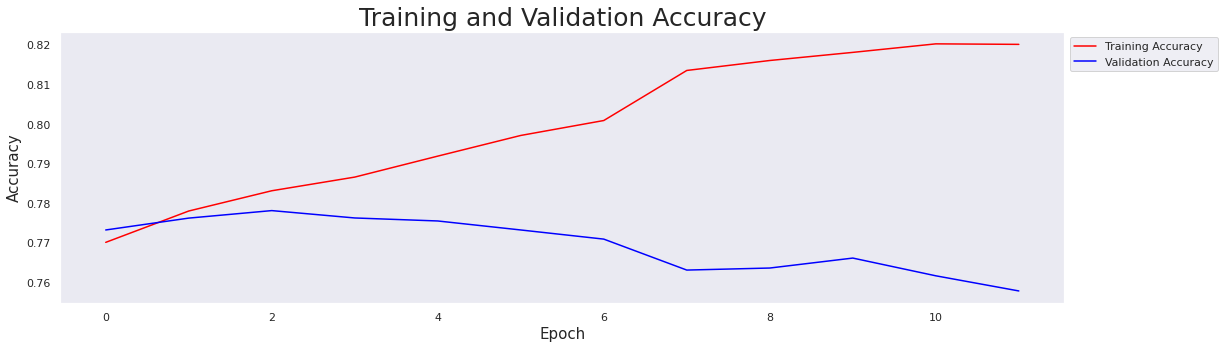

In [97]:
plot_accuracy(history)

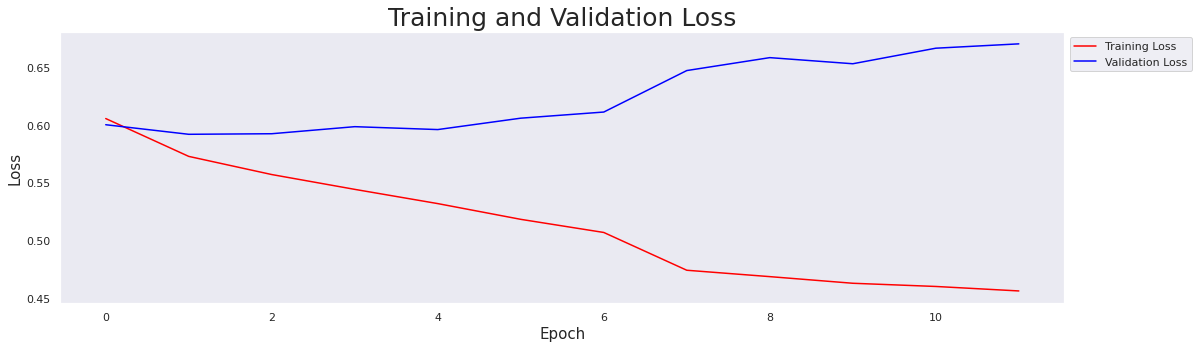

In [98]:
plot_loss(history)

**Evaluate**

In [99]:
y_pred = model.predict(pad_test)

In [105]:
def make_confusion_matrix(y_pred, y_test):
    cam = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred,axis=1))
    sns.heatmap(cam, annot=True, cmap='viridis', 
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'],
                fmt="d")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

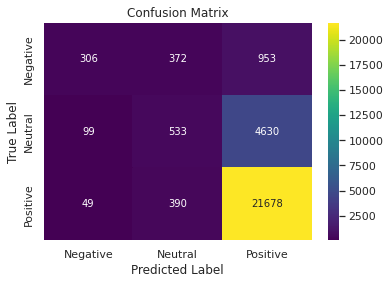

In [106]:
make_confusion_matrix(y_pred, y_test)

In [108]:
print('Accuracy Model :', accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred,axis=1)))

Accuracy Model : 0.7761806273698725
